# Data Visualization


This notebook is intended to demonstrate the use of visualization functions for ephys data and datajoint tables for storing the results.


In [1]:
import os

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")


Visualization results (e.g., figures) will be stored in tables created under the `ephys_report` schema. By default, the schema will be activated with the `ephys` schema.


In [2]:
import datajoint as dj
import datetime
from workflow_array_ephys.pipeline import ephys, probe, ephys_report


[2023-01-11 09:54:32,642][WARNING]: lab.Project and related tables will be removed in a future version of Element Lab. Please use the project schema.
[2023-01-11 09:54:32,695][WARNING]: Element Lab's "project" schema does not yet feature NWB export.Please use lab.Project and lab.Protocol tables
[2023-01-11 09:54:33,267][INFO]: Connecting cbroz@dss-db.datajoint.io:3306
[2023-01-11 09:54:33,693][INFO]: Connected cbroz@dss-db.datajoint.io:3306


First, we fetch one example unit data from the `ephys.CuratedClustering.Unit` table that will be used for this demonstration.


In [3]:
# Get the unit key
unit_number = 13

unit_key = {
    "subject": "subject6",
    "session_datetime": datetime.datetime(2021, 1, 15, 11, 16, 38),
    "insertion_number": 0,
    "paramset_idx": 0,
    "unit": unit_number,
}

ephys.CuratedClustering.Unit & unit_key


subject,session_datetime,insertion_number,paramset_idx,unit,electrode_config_hash,probe_type e.g. neuropixels_1.0,"electrode electrode index, starts at 0","cluster_quality_label cluster quality type - e.g. 'good', 'MUA', 'noise', etc.",spike_count how many spikes in this recording for this unit,"spike_times (s) spike times of this unit, relative to the start of the EphysRecording",spike_sites array of electrode associated with each spike,"spike_depths (um) array of depths associated with each spike, relative to the (0, 0) of the probe"
subject6,2021-01-15 11:16:38,0,0,13,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,13,mua,13607,=BLOB=,=BLOB=,=BLOB=


Figures can be generated either at the probe level or a single unit level. Here we start start with the unit-level visualization and import functions from `element_array_ephys.plotting.unit_level`


## Unit level visualization


- There are functions to plot the 1) **unit waveform**, 2) **autocorrelogram**, and 3) **depth waveforms** which plot the peak waveform as well as waveforms detected from neighboring sites from a given probe.

- Each figure was plotted with the _plotly_ library to allow interactive exploration of the data.


### Plot waveform


In [4]:
from element_array_ephys.plotting.unit_level import (
    plot_waveform,
    plot_auto_correlogram,
    plot_depth_waveforms,
)

# Fetch unit data
sampling_rate = (ephys.EphysRecording & unit_key).fetch1(
    "sampling_rate"
) / 1e3  # in kHz

unit_data = (
    (ephys.CuratedClustering.Unit & unit_key) * ephys.WaveformSet.PeakWaveform
).fetch1()

waveform = unit_data["peak_electrode_waveform"]
spike_times = unit_data["spike_times"]

# Fetch unit data
plot_waveform(waveform, sampling_rate)


### Plot autocorrelogram


In [13]:
# Plot Correlogram
plot_auto_correlogram(spike_times=spike_times, bin_size=0.001, window_size=1)


### Plot depth waveforms


The electrode site where the peak waveform was found will be plotted in red. The `y_range` parameter can be modified to alter the vertical range in which the neighboring waveforms are found.


In [36]:
# Plot depth Waveforms
plot_depth_waveforms(ephys, unit_key=unit_key, y_range=60)


## Probe level visualization


At the probe level, we plot a driftmap to visualize the activity of all neurons recorded on that probe per shank. Here we import the function from `element_array_ephys.plotting.probe_level`


In [37]:
from element_array_ephys.plotting.probe_level import plot_driftmap


### Plot driftmap


- Specify the probe key and the shank from that probe. Fetch `spikes_times` and `spike_depths` from all units from the shank, which will be used as an input argument for the function `plot_driftmap`.

- Units are aligned relative to the distance from the probe tip. An increase in activity (firing rates) is indicated by dark red.


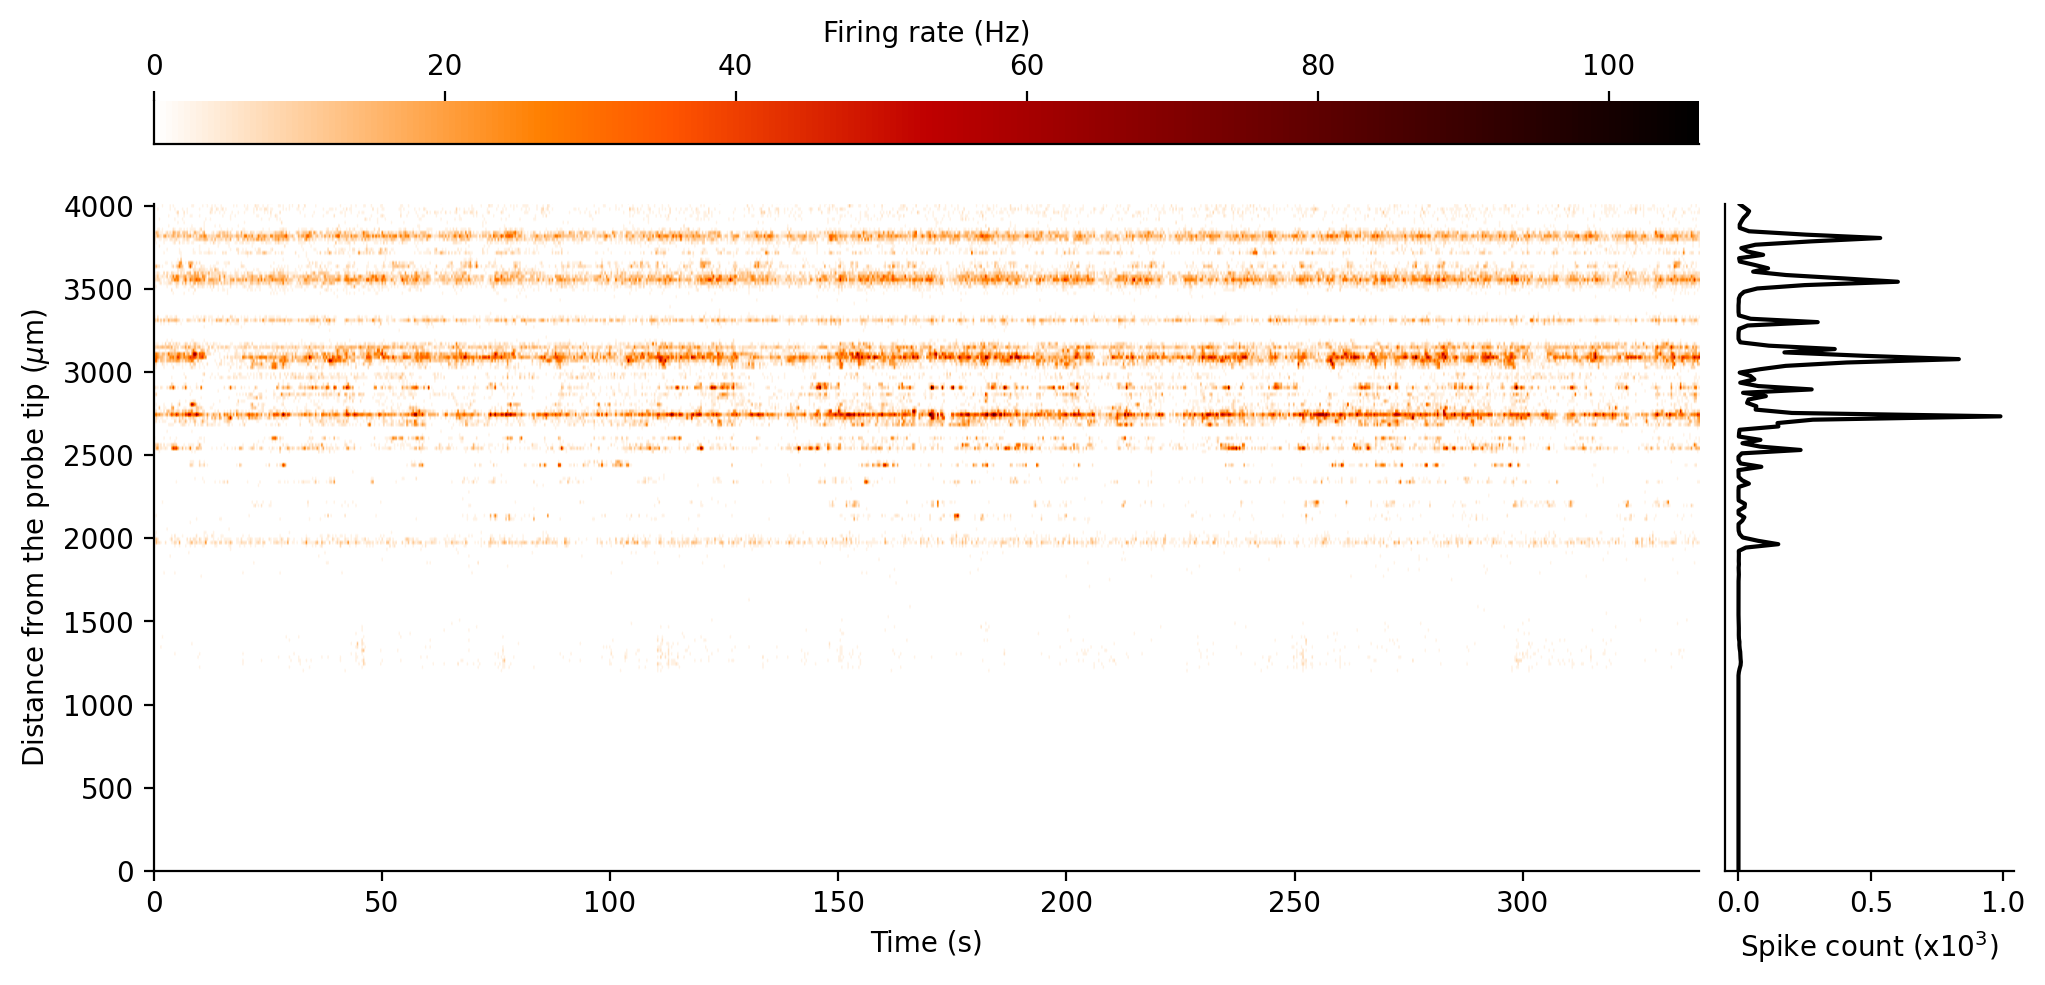

In [54]:
import matplotlib.pyplot as plt

probe_key = {
    "subject": "subject6",
    "session_datetime": datetime.datetime(2021, 1, 15, 11, 16, 38),
    "insertion_number": 0,
    "paramset_idx": 0,
}

# Fetch all units recorded from the probe and specify the shank
units = ephys.CuratedClustering.Unit & probe_key & "cluster_quality_label='good'"
shank_no = 0

table = units * ephys.ProbeInsertion * probe.ProbeType.Electrode & {"shank": shank_no}

spike_times, spike_depths = table.fetch("spike_times", "spike_depths", order_by="unit")

plot_driftmap(spike_times, spike_depths, colormap="gist_heat_r")
plt.show()


## Using ipywidget


Now, let's populate tables with these figures.

In [ ]:
ephys_report.ProbeLevelReport.populate()
ephys_report.UnitLevelReport.populate()

All of the above plots for probes and units ingested into datajoint tables can be visualized with a single widget, which can be imported as follows:


In [ ]:
from element_array_ephys.plotting.widget import main

main(ephys)

You can select a probe & shank and all the individual units associated with them via dropdown and it will automatically fetch & render the plot stored in tables from the `ephys_report` schema.


## Quality Metrics


The Element also offers Quality Metric visualizations. These are generated using an output from kilosort, `metrics.csv`. First, ensure your `QualityMetrics` table is populated with this data:


In [6]:
ephys.QualityMetrics.populate()


We'll grab an example key for demonstration.


In [4]:
my_key = ephys.QualityMetrics.fetch("KEY")[0]
my_key


{'subject': 'subject4',
 'session_datetime': datetime.datetime(2020, 2, 20, 14, 34, 56),
 'insertion_number': 0,
 'paramset_idx': 0}

The `QualityMetricFigs` class will be used to create individual plots of the quality metrics calculated by `element-array-ephys` as well as a dashboard of all metrics. Next, initialize the `QualityMetricFigs` class with the `ephys` module.


In [5]:
from element_array_ephys.plotting.qc import QualityMetricFigs

qm = QualityMetricFigs(ephys, key=my_key, dark_mode=True)
qm.plot_list  # Available plots


['firing_rate',
 'presence_ratio',
 'amp_cutoff',
 'isi_violation',
 'snr',
 'iso_dist',
 'd_prime',
 'nn_hit']

To see just one plot, we can call for it by name.


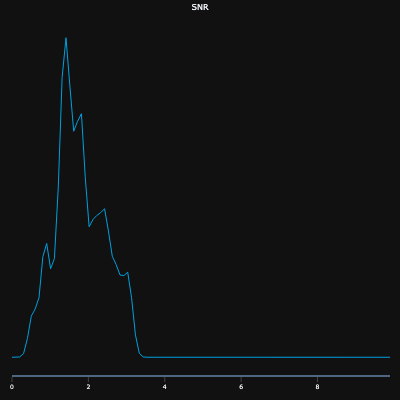

In [6]:
fig = qm.get_single_fig("snr", scale=0.5)
fig.show(
    "png"
)  # .show('png') is optional. Here, it is used to render the image within a notebook that is embedded in a browser.


Or, we can see all available plots as a grid.


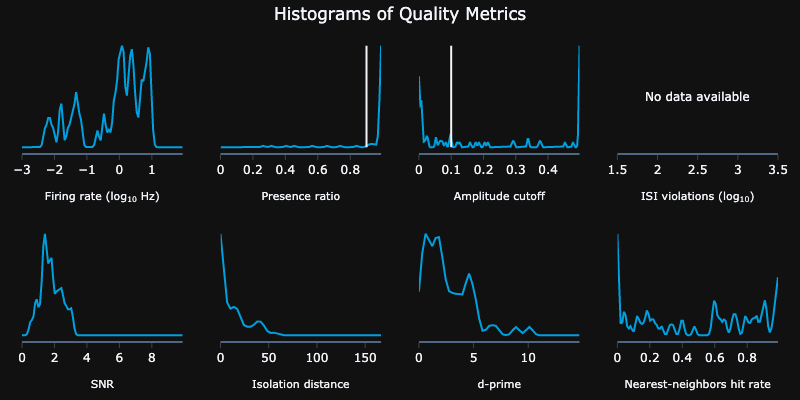

In [7]:
qm.get_grid().show("png")


We can update the key and even add or remove plots.


In [8]:
qm.key = {
    "subject": "subject4"
}  # Update the key. Must uniquely identify a row in the `QualityMetrics` table


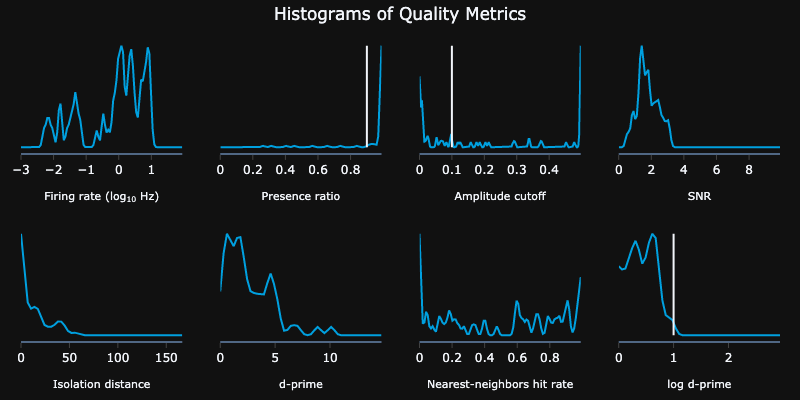

In [9]:
import numpy as np

qm.plots = {  # Add a plot to the list
    "log_d_prime": {
        "xaxis": "log d-prime",  # x-axis label
        "data": np.log10(qm.units["d_prime"]),  # Histogram data
        "bins": np.linspace(0, 3, 50),  # Histogram bins
        "vline": 1,  # Vertical line
    }
}
qm.remove_plot("isi_violation")  # Drop a plot from those rendered
qm.get_grid().show("png")


Scientists may want to apply cutoffs to the units visualized. By default, none are applied, but they can easily be set with a dictionary that corresponds to an entry in the `ephys_report.QualityMetricCutoffs` table.


In [10]:
my_cutoffs = (ephys_report.QualityMetricCutoffs & "cutoffs_id=1").fetch1()
my_cutoffs


{'cutoffs_id': 1,
 'amplitude_cutoff_maximum': 0.1,
 'presence_ratio_minimum': 0.9,
 'isi_violations_maximum': 0.5,
 'cutoffs_hash': UUID('f74ccd77-0b3a-2bf8-0bfd-ec9713b5dca8')}

In [11]:
qm.cutoffs = my_cutoffs


Relevant data items are available as a pandas dataframe in the `units` property, which correspond to the data stored in the `ephys.QualityMetric.Cluster` and `ephys.QualityMetric.Waveform` tables.


In [12]:
from IPython.display import HTML  # For pretty printing

HTML(qm.units.iloc[0:3].to_html(index=False))  # First few rows only


firing_rate,snr,presence_ratio,isi_violation,number_violation,amplitude_cutoff,isolation_distance,l_ratio,d_prime,nn_hit_rate,nn_miss_rate,silhouette_score,max_drift,cumulative_drift,contamination_rate,amplitude,duration,halfwidth,pt_ratio,repolarization_slope,recovery_slope,spread,velocity_above,velocity_below
1.316800,3.230420,0.99,NaN,None,0.5,19.9267,0.002013,5.24332,0.981333,0.000846,0.137668,134.22,3523.91,NaN,79.7310,1.24992,0.123618,NaN,0.263708,-0.001869,0.0,NaN,NaN
0.026997,1.112870,0.84,NaN,None,0.5,12.1206,0.001683,2.33009,0.185185,0.000300,-0.034638,NaN,0.00,NaN,43.4414,1.71692,0.700503,NaN,0.146716,-0.004821,3320.0,0.033097,NaN
0.016992,0.931551,0.66,NaN,None,0.5,11.9093,0.001203,2.84158,0.200000,0.000233,-0.034638,NaN,0.00,NaN,42.5355,1.59330,1.208710,NaN,0.006649,-0.016113,2060.0,0.060787,NaN
